In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib, datetime
import matplotlib.pyplot as plt

from utils import get_mongo_db

In [14]:
db = get_mongo_db()

Connecting to MongoDB at localhost:27017...


In [15]:
repos = list(db.ch_repositories_view.find())

data = [{'language': r['language'], 'created_at': r['created_at']} for r in repos]

df = pd.DataFrame(data)

ts = list(df['created_at'])
index = pd.DatetimeIndex(data=ts)
df = pd.DataFrame(data, index=index)
groups = df.groupby([(df.index.year),(df.index.month)])

In [16]:
res = []

for (year, month), rows in groups:
    by_lang = rows['language'].value_counts().to_dict()
    for lang in by_lang: 
        res.append({
                'language': lang,
                'count': by_lang[lang],
                'year_month': '{}-{}-{}'.format(year, month, '01')
            })

counts = pd.DataFrame(res)
counts.sample(10)

,count,language,year_month
2518,139,PHP,2015-1-01
1865,1,Processing,2014-1-01
182,2,Perl,2009-9-01
3958,17,R,2016-10-01
2345,2,Smalltalk,2014-10-01
3313,127,PHP,2016-1-01
2339,154,Python,2014-10-01
3475,67,C#,2016-3-01
2573,8,Haskell,2015-2-01
3430,2,Processing,2016-2-01


In [50]:
total = counts.groupby('language').sum().sort_values(by='count', ascending=False)
languages = set(total[0:10].index)

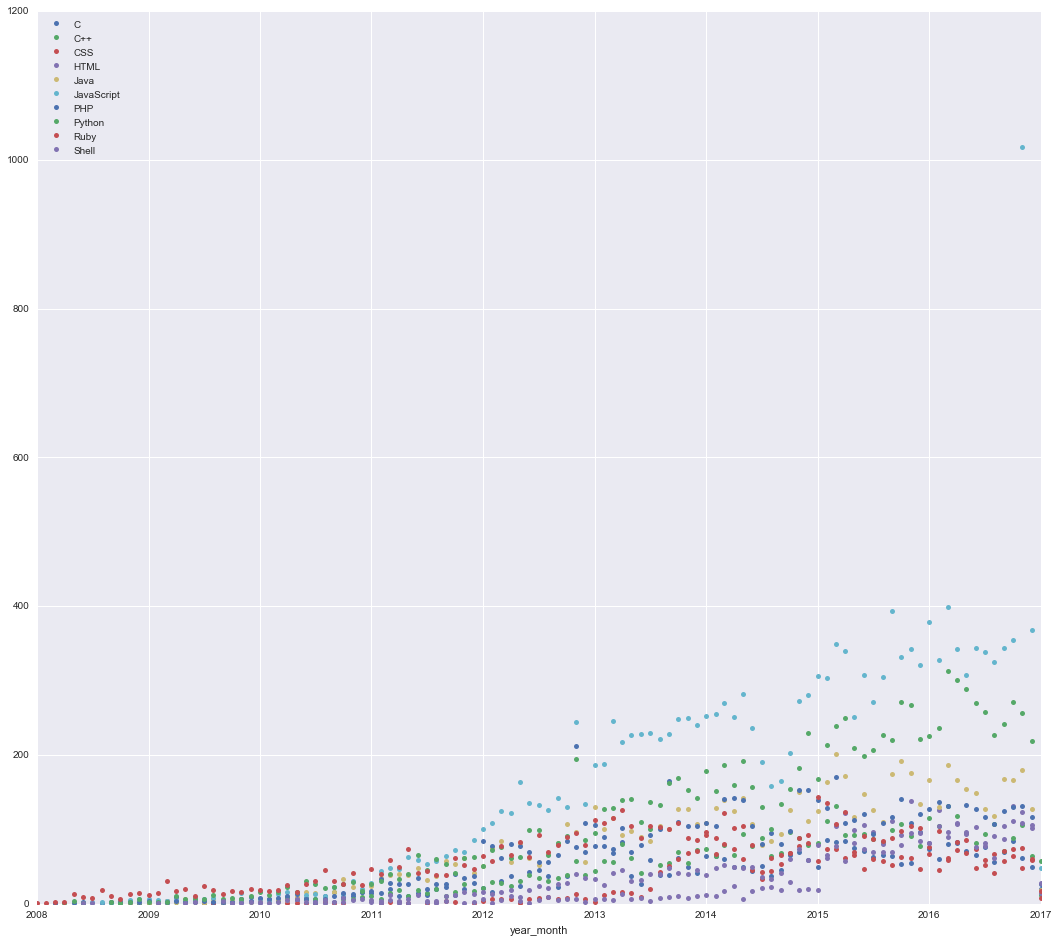

In [51]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

years = YearLocator()
months = MonthLocator()
yearsFmt = DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(18, 16))

def plot_date(df, x, y, l, datetimeformat):
    if not isinstance(y, list):
        y = [y]
    for yi in y:
        x_data = df[x].apply(
            lambda z: matplotlib.dates.date2num(
                datetime.datetime.strptime(z, datetimeformat)))
        
        ax.plot_date(x_data, df[yi], label=l, ms=5)

    plt.xlabel(x)
    
for key, grp in counts.groupby(['language']):
    if key not in languages:
        continue

    plot_date(grp, x='year_month', y=['count'], l=key, datetimeformat='%Y-%m-%d')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()

plt.legend(loc='best')
plt.show()